# Временные ряды 3. 

# Домашнее задание

# Моделируем временные ряды по ARIMA

# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

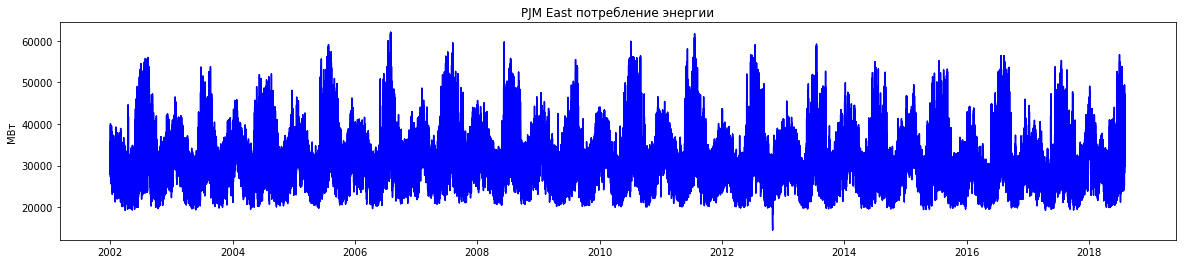

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

### Методы анализа рядов

При построении моделей временных обычно говорят о следующих типах моделей:
- статистические, где зависимость будущего значения от прошлого задается в виде некоторого уравнения, а их делят на регрессионные модели (линейная регрессия, нелинейная регрессия), авторегрессионные модели (ARIMAX), модель экспоненциального сглаживания и т.д. Эта форма описания ряда содержит представление о формуле с параметрами, которые хорошо обходят точки соответствующие прошлому и, наверное, будут хорошо описывать будущее. 
- структурные модели, где зависимость будущего значения от прошлого задается в виде некоторой структуры и правил перехода по ней. К ним относят нейросетевые модели, модели на базе цепей Маркова, модели на базе классификационно-регрессионных деревьев и т.д.
- спектральные модели, которые основаны на определении временного ряда как совокупности простых процессов разной частоты.

Таким образом, возвращаясь к объектам реального мира для статистических моделей, если наш кот бегает за игрушкой и нам известна масса и размер котенка, а так же на основании предшествующих измерений нам удалось оценить корреляцию возраста, размера и массы котенка с его скоростью и маневренностью, то мы сможем предсказать, как быстро будет бегать питомец в будущем.  
С другой стороны модели на основе методов обучения, предполагают, что связь доступных для измерения свойств объекта или предшествующих значений ряда можно получить, если взять достаточно сложную функцию с параметрами и адаптировать(обучить) эти параметры опираясь на известные примеры. Близкие идеи реализует и спектральная модель описания явлений, т.к. ее задача состоит в подборе(вычислении) амплитуд простых процессов, из которых будем складывать описание прошлого.

Все подходы к моделированию рядов объединяет предположение, что будущее в некоторой степени зависит (и повторяет) прошлое. 

Перейдем к рассмотрению способов описания рядов на формальном уровне. По форме можно выделить две основных модели :
- аддитивная :  y(y) = X_trend(t) + X_cicle(t) + e(t)
- мультипликативная :  y(y) = X_trend(t) X_cicle(t) e(t)

Здесь y(y) - изменение значений ряда по времени, X_trend(t) - трендовая составляющая, X_cicle(t) - циклическая с оставляющая и случайная част e(t) ряда.
Разница между ними состоит в способе учета факторов влияющих на общее решение.

Рассмотрим вариант решения задачи описания временного ряда в форме модели ARIMA (статистическая форма анализа ряда) на базе пакета statsmodels http://www.statsmodels.org/dev/tsa.html.

In [5]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

ARMA - Авторегрессионная модель скользящего среднего. В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда (для нефти и Потребления энергии мы из примерно определили в процессе ресемплинга на разные интервалы).

ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построена для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонеты MA.


In [6]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

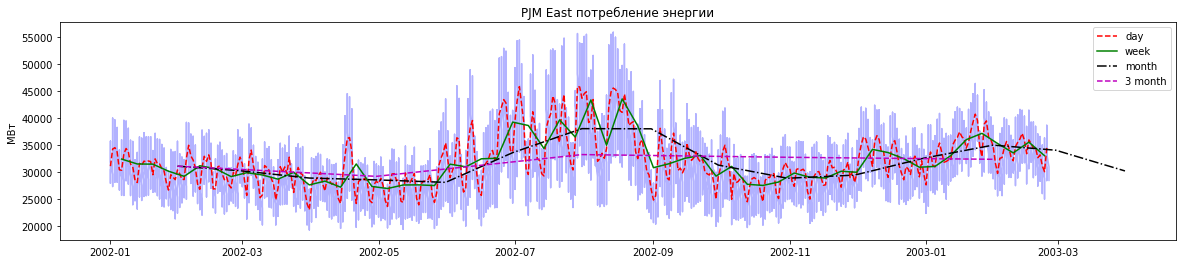

In [7]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Но сначала посмотрим , что можно увидеть для исходной модели (работает очень долго)

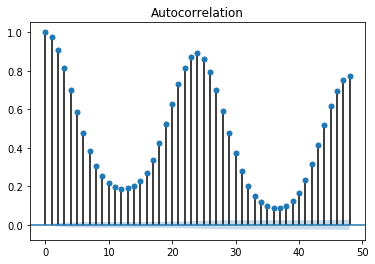

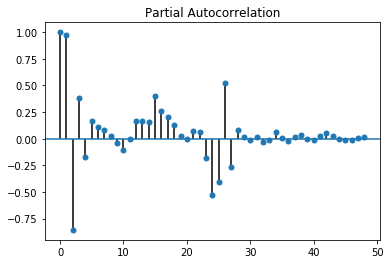

In [8]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=24*2)
plt.show()

Получили оценку автокорреляции часовой модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 24 часа(никто и не сомневался см.рис. Autocorrelation) и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 24 часов. Первый график говорит о параметре части MA(24) - т.е следует рассматривать ресемплинг модели (поскольку авторегрессия 24) на дневные модели. По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда. Мы помним, что ADF нам эту нестационарность уже диагностировал (временные ряды 2). Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

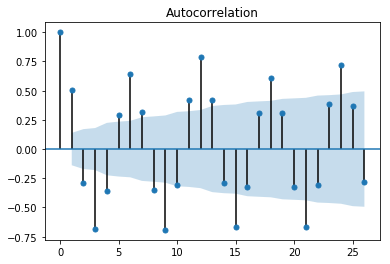

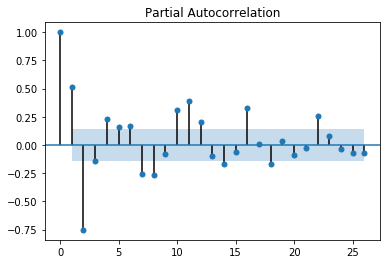

In [9]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

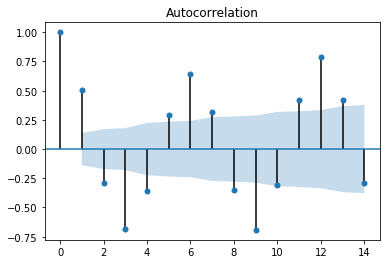

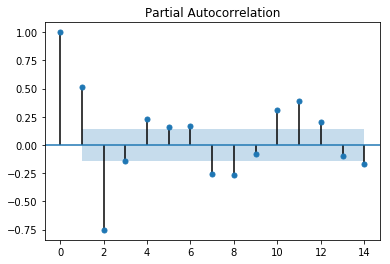

In [10]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=14)
plt.show()

In [16]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 6 месяцев
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs , 12] 


In [17]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 2]    : ps,ds,qs, S= [0, 1, 1, 12]


In [18]:
#для построения модели используем все данные, кроме 12-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[1, 2, 2]x[0, 1, 1, 12] - AIC:2860.0715535954178


In [19]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 12)   Log Likelihood               -1425.036
Date:                            Thu, 23 Jan 2020   AIC                           2860.072
Time:                                    10:24:04   BIC                           2875.416
Sample:                                         0   HQIC                          2866.303
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

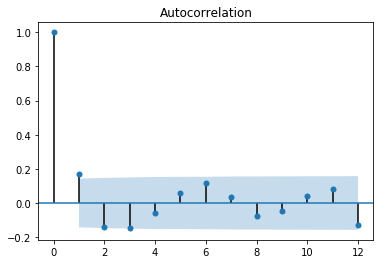

In [20]:
sm.graphics.tsa.plot_acf(results.resid, lags=12)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

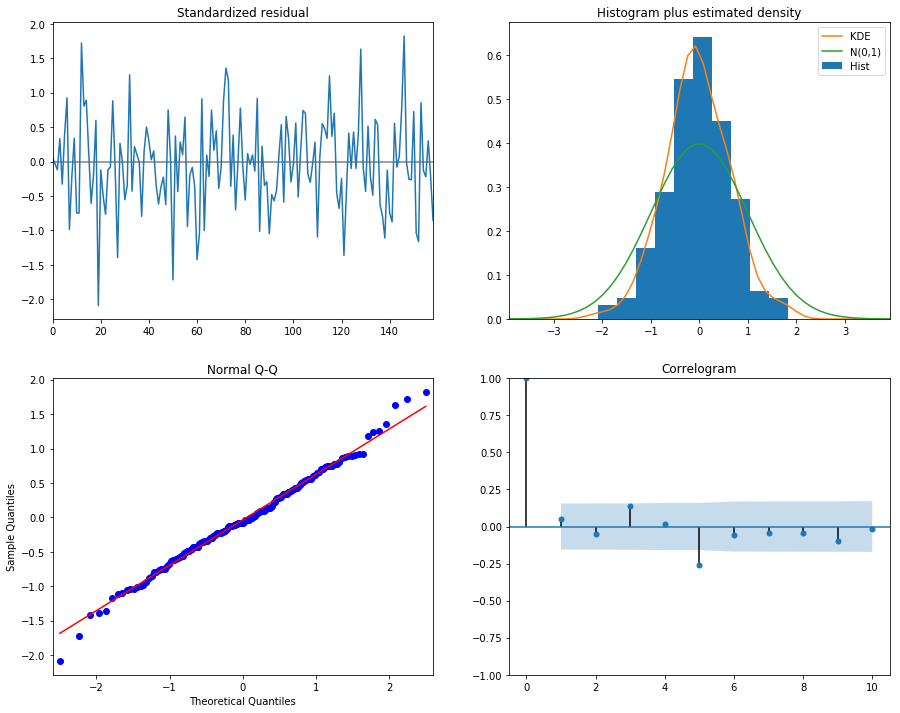

In [21]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными, кроме 5 месяца, возможно, это связанно с неоптимальными параметрами текущей модели.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    
- задаем длину сезона (здесь 26 недель - зимой греем, летом кондиционируем и расход энергии примерно одинаковый)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [24]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# # зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [25]:
%%time
warnings.filterwarnings("ignore") # отключает предупреждения
lst_of_result = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            lst_of_result.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:3992.5110075928433
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:3604.136774693245
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3307.3157105213554
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:2823.40519565099
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2598.6895974048684
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2365.3245731795387
ARIMA(0, 0, 0)x(0, 2, 0, 12)3 - AIC:2759.2770606314034
ARIMA(0, 0, 0)x(0, 2, 1, 12)3 - AIC:2479.012857386141
ARIMA(0, 0, 0)x(0, 2, 2, 12)3 - AIC:2246.623927870595
ARIMA(0, 0, 0)x(1, 0, 0, 12)3 - AIC:2846.1162304291183
ARIMA(0, 0, 0)x(1, 0, 1, 12)3 - AIC:2826.005505905166
ARIMA(0, 0, 0)x(1, 0, 2, 12)3 - AIC:2574.8196730610825
ARIMA(0, 0, 0)x(1, 1, 0, 12)3 - AIC:2605.476783568567
ARIMA(0, 0, 0)x(1, 1, 1, 12)3 - AIC:2588.3075909563468
ARIMA(0, 0, 0)x(1, 1, 2, 12)3 - AIC:2361.6550720952437
ARIMA(0, 0, 0)x(1, 2, 0, 12)3 - AIC:2496.3626822009487
ARIMA(0, 0, 0)x(1, 2, 1, 12)3 - AIC:2466.621236592328
ARIMA(0, 0, 0)x(1, 2, 2, 12)3 - AIC:2228.5679311093936
ARIMA(0, 0, 0)x(2,

ARIMA(0, 1, 2)x(1, 2, 1, 12)3 - AIC:2350.3721490929775
ARIMA(0, 1, 2)x(1, 2, 2, 12)3 - AIC:2118.766727468061
ARIMA(0, 1, 2)x(2, 0, 0, 12)3 - AIC:2577.4092631588064
ARIMA(0, 1, 2)x(2, 0, 1, 12)3 - AIC:2559.601105187735
ARIMA(0, 1, 2)x(2, 0, 2, 12)3 - AIC:2507.771427962949
ARIMA(0, 1, 2)x(2, 1, 0, 12)3 - AIC:2355.5927290522577
ARIMA(0, 1, 2)x(2, 1, 1, 12)3 - AIC:2363.8118132258087
ARIMA(0, 1, 2)x(2, 1, 2, 12)3 - AIC:2298.738310682241
ARIMA(0, 1, 2)x(2, 2, 0, 12)3 - AIC:2213.438120981777
ARIMA(0, 1, 2)x(2, 2, 1, 12)3 - AIC:2175.869097229759
ARIMA(0, 1, 2)x(2, 2, 2, 12)3 - AIC:2120.4887323631733
ARIMA(0, 2, 0)x(0, 0, 0, 12)3 - AIC:3250.6050318988573
ARIMA(0, 2, 0)x(0, 0, 1, 12)3 - AIC:2987.528020670859
ARIMA(0, 2, 0)x(0, 0, 2, 12)3 - AIC:2753.662297501023
ARIMA(0, 2, 0)x(0, 1, 0, 12)3 - AIC:2977.1929897265522
ARIMA(0, 2, 0)x(0, 1, 1, 12)3 - AIC:2709.605470860013
ARIMA(0, 2, 0)x(0, 1, 2, 12)3 - AIC:2481.9697582236095
ARIMA(0, 2, 0)x(0, 2, 0, 12)3 - AIC:2908.6920824446256
ARIMA(0, 2, 0)x(0, 

ARIMA(1, 0, 2)x(0, 1, 2, 12)3 - AIC:2308.722913086351
ARIMA(1, 0, 2)x(0, 2, 0, 12)3 - AIC:2714.4275511489423
ARIMA(1, 0, 2)x(0, 2, 1, 12)3 - AIC:2422.075435308439
ARIMA(1, 0, 2)x(0, 2, 2, 12)3 - AIC:2189.7748521585236
ARIMA(1, 0, 2)x(1, 0, 0, 12)3 - AIC:2885.865677635984
ARIMA(1, 0, 2)x(1, 0, 1, 12)3 - AIC:2847.196732168911
ARIMA(1, 0, 2)x(1, 0, 2, 12)3 - AIC:2623.649826856976
ARIMA(1, 0, 2)x(1, 1, 0, 12)3 - AIC:2568.3368292914065
ARIMA(1, 0, 2)x(1, 1, 1, 12)3 - AIC:2529.263536644116
ARIMA(1, 0, 2)x(1, 1, 2, 12)3 - AIC:2315.4747760920923
ARIMA(1, 0, 2)x(1, 2, 0, 12)3 - AIC:2464.8311554033126
ARIMA(1, 0, 2)x(1, 2, 1, 12)3 - AIC:2412.1982631908113
ARIMA(1, 0, 2)x(1, 2, 2, 12)3 - AIC:2163.5203628012923
ARIMA(1, 0, 2)x(2, 0, 0, 12)3 - AIC:2570.696553549651
ARIMA(1, 0, 2)x(2, 0, 1, 12)3 - AIC:2661.88209240152
ARIMA(1, 0, 2)x(2, 0, 2, 12)3 - AIC:2625.6485161380297
ARIMA(1, 0, 2)x(2, 1, 0, 12)3 - AIC:2342.1189975481275
ARIMA(1, 0, 2)x(2, 1, 1, 12)3 - AIC:2339.7863417305143
ARIMA(1, 0, 2)x(2, 

ARIMA(1, 2, 1)x(2, 1, 0, 12)3 - AIC:2354.3048202899845
ARIMA(1, 2, 1)x(2, 1, 1, 12)3 - AIC:2351.710890239517
ARIMA(1, 2, 1)x(2, 1, 2, 12)3 - AIC:2328.1493139310096
ARIMA(1, 2, 1)x(2, 2, 0, 12)3 - AIC:2200.492700643228
ARIMA(1, 2, 1)x(2, 2, 1, 12)3 - AIC:2170.676134153995
ARIMA(1, 2, 1)x(2, 2, 2, 12)3 - AIC:2153.7209908862387
ARIMA(1, 2, 2)x(0, 0, 0, 12)3 - AIC:3163.6265555565124
ARIMA(1, 2, 2)x(0, 0, 1, 12)3 - AIC:2867.419761968977
ARIMA(1, 2, 2)x(0, 0, 2, 12)3 - AIC:2629.8310827470114
ARIMA(1, 2, 2)x(0, 1, 0, 12)3 - AIC:2807.371118231952
ARIMA(1, 2, 2)x(0, 1, 1, 12)3 - AIC:2528.395439999379
ARIMA(1, 2, 2)x(0, 1, 2, 12)3 - AIC:2316.9062978796815
ARIMA(1, 2, 2)x(0, 2, 0, 12)3 - AIC:2736.4391617817532
ARIMA(1, 2, 2)x(0, 2, 1, 12)3 - AIC:2438.5644215330053
ARIMA(1, 2, 2)x(0, 2, 2, 12)3 - AIC:2201.740294577651
ARIMA(1, 2, 2)x(1, 0, 0, 12)3 - AIC:2831.4763421436382
ARIMA(1, 2, 2)x(1, 0, 1, 12)3 - AIC:2787.507198779575
ARIMA(1, 2, 2)x(1, 0, 2, 12)3 - AIC:2564.56152860104
ARIMA(1, 2, 2)x(1, 1

ARIMA(2, 1, 1)x(1, 0, 1, 12)3 - AIC:2736.7220229803747
ARIMA(2, 1, 1)x(1, 0, 2, 12)3 - AIC:2550.1073515815906
ARIMA(2, 1, 1)x(1, 1, 0, 12)3 - AIC:2551.8188736477364
ARIMA(2, 1, 1)x(1, 1, 1, 12)3 - AIC:2527.2772500872707
ARIMA(2, 1, 1)x(1, 1, 2, 12)3 - AIC:2309.243971778826
ARIMA(2, 1, 1)x(1, 2, 0, 12)3 - AIC:2438.721723589143
ARIMA(2, 1, 1)x(1, 2, 1, 12)3 - AIC:2365.8216103869768
ARIMA(2, 1, 1)x(1, 2, 2, 12)3 - AIC:2133.007841881601
ARIMA(2, 1, 1)x(2, 0, 0, 12)3 - AIC:2536.2247158315313
ARIMA(2, 1, 1)x(2, 0, 1, 12)3 - AIC:2523.788609818708
ARIMA(2, 1, 1)x(2, 0, 2, 12)3 - AIC:2551.552709023108
ARIMA(2, 1, 1)x(2, 1, 0, 12)3 - AIC:2321.6293373900744
ARIMA(2, 1, 1)x(2, 1, 1, 12)3 - AIC:2323.1869159782827
ARIMA(2, 1, 1)x(2, 1, 2, 12)3 - AIC:2311.3493242445866
ARIMA(2, 1, 1)x(2, 2, 0, 12)3 - AIC:2180.391580523349
ARIMA(2, 1, 1)x(2, 2, 1, 12)3 - AIC:2139.1685009137063
ARIMA(2, 1, 1)x(2, 2, 2, 12)3 - AIC:2133.985651407622
ARIMA(2, 1, 2)x(0, 0, 0, 12)3 - AIC:3001.296552547406
ARIMA(2, 1, 2)x(0,

In [26]:
min(lst_of_result) 

2100.3035556137916

Лучшие результаты на недельных данных параметры модели SARIMAX(2, 2, 2)x(0, 2, 2, 12)3 - AIC:2100.3035556137916

In [36]:
#для построения модели используем все данные, кроме 12 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=[2,2,2],
                                seasonal_order=[0,2,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:',results_opt.aic)


AIC: 2500.2916841868027


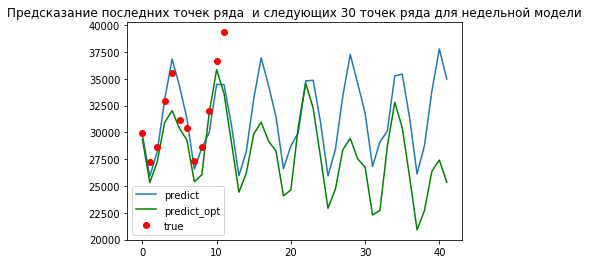

In [29]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда для недельной модели')
plt.legend()

plt.show()

Посмотрим на график недельной модели

In [32]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-12],order=[0,0,1],
                                seasonal_order=[1,1,2,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_w_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 14254.93660296172


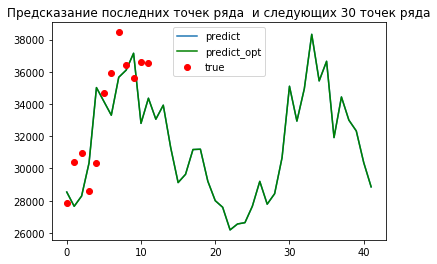

In [34]:
pred_dynamic = results_w_opt.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

Видно, что предсказание новых точек тем слабее, чем дальше от последней известной точки ряда. Однако модель для предсказания по месяцам предсказывает лучше чем недельная.  Это связанно с тем, что в ряду по месяцам практически отсутствует цикличность и он более равномерен, чем ряд по неделям.

## Сохраниение модели

In [29]:
results_opt.save('rez_model.h5') # и обратно t_rez = sm.load('rez_model.h5')